<a href="https://colab.research.google.com/github/thejayden/FYP/blob/main/dcgan_v0_revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***DCGAN Version 0 with modified generator and discriminator layers***

##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Deep Convolutional Generative Adversarial Network

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/dcgan">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/dcgan.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to generate images of handwritten digits using a [Deep Convolutional Generative Adversarial Network](https://arxiv.org/pdf/1511.06434.pdf) (DCGAN). The code is written using the [Keras Sequential API](https://www.tensorflow.org/guide/keras) with a `tf.GradientTape` training loop.

### Setup

In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'2.7.0'

In [4]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-d22po5qj
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-d22po5qj
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=155965 sha256=0816a1deab945f0d50dde9d87b3042780937c2edacb3310572575e9a98f215b2
  Stored in directory: /tmp/pip-ephem-wheel-cache-inonlevu/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [5]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [6]:
!git clone https://github.com/thejayden/gpr_field_data.git
# !git clone -b color https://github.com/thejayden/gpr_field_data.git

Cloning into 'gpr_field_data'...
remote: Enumerating objects: 401, done.
remote: Counting objects: 100% (401/401), done.
remote: Compressing objects: 100% (401/401), done.
remote: Total 401 (delta 0), reused 401 (delta 0), pack-reused 0
Receiving objects: 100% (401/401), 4.42 MiB | 18.20 MiB/s, done.


In [7]:
    from keras.preprocessing.image import load_img, img_to_array

    data = []
    dir_root = os.path.join(os.getcwd(), 'gpr_field_data')
    file_list = os.listdir(dir_root)

    for file_name in file_list:
      if file_name.endswith(".png"):
        data.append(os.path.join(dir_root, file_name))

    data_list = []

    for image_name in data:
        # image_loaded = load_img(image_name,
        #                         color_mode='grayscale',
        #                         target_size=(64, 128),
        #                         interpolation='bicubic')
        image_loaded = load_img(image_name)
        image = img_to_array(image_loaded)
        data_list.append(image)

    print("data_list[0] = ", data_list[0])

data_list[0] =  [[[ 54.  54.  54.]
  [ 43.  43.  43.]
  [ 22.  22.  22.]
  ...
  [  8.   8.   8.]
  [  8.   8.   8.]
  [  8.   8.   8.]]

 [[138. 138. 138.]
  [135. 135. 135.]
  [129. 129. 129.]
  ...
  [125. 125. 125.]
  [125. 125. 125.]
  [125. 125. 125.]]

 [[134. 134. 134.]
  [134. 134. 134.]
  [135. 135. 135.]
  ...
  [135. 135. 135.]
  [135. 135. 135.]
  [135. 135. 135.]]

 ...

 [[132. 132. 132.]
  [132. 132. 132.]
  [132. 132. 132.]
  ...
  [129. 129. 129.]
  [129. 129. 129.]
  [128. 128. 128.]]

 [[133. 133. 133.]
  [133. 133. 133.]
  [133. 133. 133.]
  ...
  [129. 129. 129.]
  [129. 129. 129.]
  [129. 129. 129.]]

 [[134. 134. 134.]
  [134. 134. 134.]
  [134. 134. 134.]
  ...
  [130. 130. 130.]
  [130. 130. 130.]
  [130. 130. 130.]]]


### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [8]:
train_images = np.array(data_list).astype('float32')
train_images.shape

(210, 256, 256, 3)

In [9]:
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
print(train_images.shape)
print(train_images.dtype)

(210, 256, 256, 3)
float32


In [10]:
print(train_images[0])

[[[-0.5764706  -0.5764706  -0.5764706 ]
  [-0.6627451  -0.6627451  -0.6627451 ]
  [-0.827451   -0.827451   -0.827451  ]
  ...
  [-0.9372549  -0.9372549  -0.9372549 ]
  [-0.9372549  -0.9372549  -0.9372549 ]
  [-0.9372549  -0.9372549  -0.9372549 ]]

 [[ 0.08235294  0.08235294  0.08235294]
  [ 0.05882353  0.05882353  0.05882353]
  [ 0.01176471  0.01176471  0.01176471]
  ...
  [-0.01960784 -0.01960784 -0.01960784]
  [-0.01960784 -0.01960784 -0.01960784]
  [-0.01960784 -0.01960784 -0.01960784]]

 [[ 0.05098039  0.05098039  0.05098039]
  [ 0.05098039  0.05098039  0.05098039]
  [ 0.05882353  0.05882353  0.05882353]
  ...
  [ 0.05882353  0.05882353  0.05882353]
  [ 0.05882353  0.05882353  0.05882353]
  [ 0.05882353  0.05882353  0.05882353]]

 ...

 [[ 0.03529412  0.03529412  0.03529412]
  [ 0.03529412  0.03529412  0.03529412]
  [ 0.03529412  0.03529412  0.03529412]
  ...
  [ 0.01176471  0.01176471  0.01176471]
  [ 0.01176471  0.01176471  0.01176471]
  [ 0.00392157  0.00392157  0.00392157]]

 [

In [11]:
# BUFFER_SIZE = 60000
num_train_images = train_images.shape[0]
BATCH_SIZE = 1
input_shape=1000

In [12]:
# Batch and shuffle the data
# train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).batch(BATCH_SIZE)

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [13]:
def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*1024, use_bias=False, input_shape=(input_shape,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4, 4, 1024)))
    assert model.output_shape == (None, 4, 4, 1024)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 128, 128, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 256, 256, 3)

    return model

In [14]:
# declares the generator
generator = generator_model()

In [15]:
generator.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7f18c0669c50>>

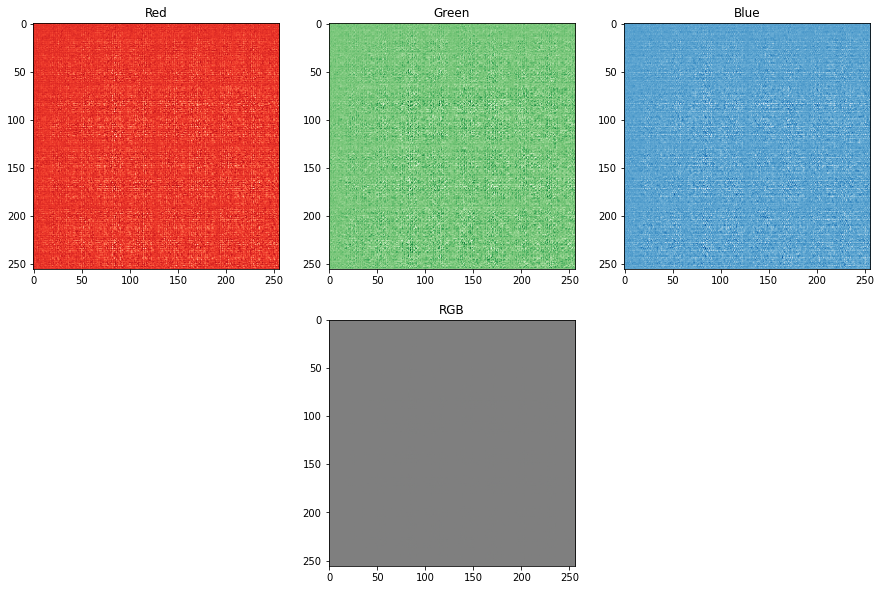

In [16]:
noise = tf.random.normal([1, input_shape])
generated_image = generator(noise, training=False)

# show output of untrained generator
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.title("Red")
plt.imshow((generated_image[0, :, :, 0] + 1)/2, cmap='Reds')
plt.subplot(2, 3, 2)
plt.title("Green")
plt.imshow((generated_image[0, :, :, 1] + 1)/2, cmap='Greens')
plt.subplot(2, 3, 3)
plt.title("Blue")
plt.imshow((generated_image[0, :, :, 2] + 1)/2, cmap='Blues')
plt.subplot(2, 3, 5)
plt.title("RGB")
plt.imshow((generated_image[0, :, :, :] + 1)/2)

Use the (as yet untrained) generator to create an image.

### The Discriminator

The discriminator is a CNN-based image classifier.

In [17]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same',
                                     input_shape=[256, 256, 3]))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(1024, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [18]:
# def discriminator_model():
#     model = tf.keras.Sequential()
        
#     #add Gaussian noise to prevent Discriminator overfitting
#     model.add(layers.GaussianNoise(0.2, input_shape = [256, 256, 3]))
    
#     #256x256x3 Image
#     model.add(layers.Conv2D(filters = 8, kernel_size = 3, padding = 'same'))
#     model.add(layers.LeakyReLU(0.2))
#     model.add(layers.Dropout(0.25))
#     model.add(layers.AveragePooling2D())
    
#     #128x128x8
#     model.add(layers.Conv2D(filters = 16, kernel_size = 3, padding = 'same'))
#     model.add(layers.BatchNormalization(momentum = 0.7))
#     model.add(layers.LeakyReLU(0.2))
#     model.add(layers.Dropout(0.25))
#     model.add(layers.AveragePooling2D())
    
#     #64x64x16
#     model.add(layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same'))
#     model.add(layers.BatchNormalization(momentum = 0.7))
#     model.add(layers.LeakyReLU(0.2))
#     model.add(layers.Dropout(0.25))
#     model.add(layers.AveragePooling2D())
    
#     #32x32x32
#     model.add(layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
#     model.add(layers.BatchNormalization(momentum = 0.7))
#     model.add(layers.LeakyReLU(0.2))
#     model.add(layers.Dropout(0.25))
#     model.add(layers.AveragePooling2D())
    
#     #16x16x64
#     model.add(layers.Conv2D(filters = 128, kernel_size = 3, padding = 'same'))
#     model.add(layers.BatchNormalization(momentum = 0.7))
#     model.add(layers.LeakyReLU(0.2))
#     model.add(layers.Dropout(0.25))
#     model.add(layers.AveragePooling2D())
    
#     #8x8x128
#     model.add(layers.Conv2D(filters = 256, kernel_size = 3, padding = 'same'))
#     model.add(layers.BatchNormalization(momentum = 0.7))
#     model.add(layers.LeakyReLU(0.2))
#     model.add(layers.Dropout(0.25))
#     model.add(layers.AveragePooling2D())
    
#     #4x4x256
#     model.add(layers.Flatten())
    
#     #256
#     model.add(layers.Dense(128))
#     model.add(layers.LeakyReLU(0.2))

#     model.add(layers.Dense(1, activation = 'sigmoid'))
    
#     return model

In [19]:
# Declares the discriminator
discriminator = discriminator_model()

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [20]:
# discriminator = make_discriminator_model()
# decision = discriminator(generated_image)
# print (decision)

# discriminator = discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.4999987]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [21]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [22]:
# def discriminator_loss(real_output, fake_output):
#     # [8][9] Using soft labels
#     real_values = np.random.uniform(0.95, 1.0, size = real_output.get_shape())
#     fake_values = np.random.uniform(0.0, 0.05, size = fake_output.get_shape())

#     real_loss = cross_entropy(real_values, real_output)
#     fake_loss = cross_entropy(fake_values, fake_output)
#     total_loss = real_loss + fake_loss
#     return total_loss

In [23]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [24]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [25]:
# discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [26]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [27]:
# generator_optimizer = tf.keras.optimizers.Adam(1e-5)

The discriminator and the generator optimizers are different since you will train two networks separately.

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [28]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [29]:
# EPOCHS = 50
# noise_dim = 100
# num_examples_to_generate = 16

# # You will reuse this seed overtime (so it's easier)
# # to visualize progress in the animated GIF)
# seed = tf.random.normal([num_examples_to_generate, noise_dim])

noise_dim = input_shape
num_examples_to_generate = 9

# Generate seeded noise to make the evolution more visible in the gif
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [30]:
# BATCH_SIZE = 27

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [31]:
# def train(dataset, epochs):
#   for epoch in range(epochs):
#     start = time.time()

#     for image_batch in dataset:
#       train_step(image_batch)

#     # Produce images for the GIF as you go
#     display.clear_output(wait=True)
#     generate_and_save_images(generator,
#                              epoch + 1,
#                              seed)

#     # Save the model every 15 epochs
#     if (epoch + 1) % 15 == 0:
#       checkpoint.save(file_prefix = checkpoint_prefix)

#     print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

#   # Generate after the final epoch
#   display.clear_output(wait=True)
#   generate_and_save_images(generator,
#                            epochs,
#                            seed)


def train(dataset, start_epoch, epochs):
    for epoch in range(start_epoch, start_epoch + epochs):
        start = time.time()
        
        batches = 0
        for image_batch in dataset:
            print(".", end = '')
            train_step(image_batch)

            # The loop needs to be broken manually, since a generator is being
            # used and it loops indefinitely
            batches += 1
            if batches >= num_train_images / BATCH_SIZE:
                break

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 10 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

**Generate and save images**


In [32]:
# def generate_and_save_images(model, epoch, test_input):
#   # Notice `training` is set to False.
#   # This is so all layers run in inference mode (batchnorm).
#   predictions = model(test_input, training=False)

#   fig = plt.figure(figsize=(4, 4))

#   for i in range(predictions.shape[0]):
#       plt.subplot(4, 4, i+1)
#       plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
#       plt.axis('off')

#   plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
#   plt.show()

def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(10, 10))

    for i in range(predictions.shape[0]):
        plt.subplot(3, 3, i+1)
        plt.imshow((predictions[i, :, :, :] + 1)/2)
        plt.axis('off')

    plt.savefig('./output' + '/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

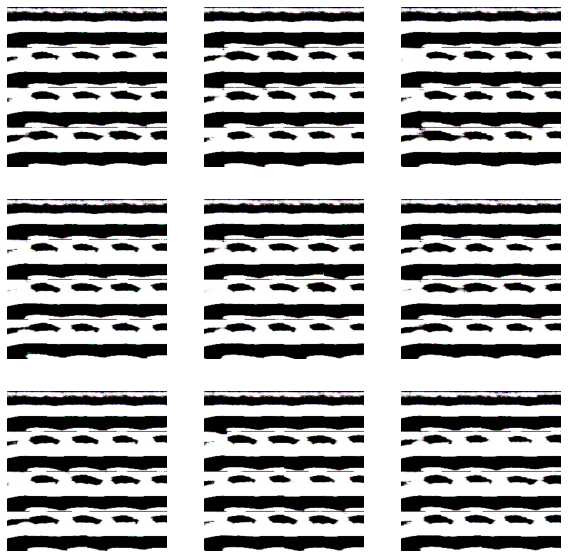

Time for epoch 97 is 10.114531755447388 sec
..........................................................

In [ ]:
# train(train_dataset, EPOCHS)
if not os.path.exists('./output'):
    os.makedirs('./output')

last_trained_epoch = 0
epochs_to_train = 500

train(train_dataset, last_trained_epoch, epochs_to_train)

Restore the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# import shutil

# shutil.rmtree("./gpr_field_data/dataset1")


In [ ]:
!zip -r /content/output_hyperbola.zip /content/output

In [ ]:
from google.colab import files
files.download("/content/output_hyperbola.zip")

## Create a GIF


In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(epochs_to_train)

Use `imageio` to create an animated gif using the images saved during training.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('./output/'+'image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

## Next steps


This tutorial has shown the complete code necessary to write and train a GAN. As a next step, you might like to experiment with a different dataset, for example the Large-scale Celeb Faces Attributes (CelebA) dataset [available on Kaggle](https://www.kaggle.com/jessicali9530/celeba-dataset). To learn more about GANs see the [NIPS 2016 Tutorial: Generative Adversarial Networks](https://arxiv.org/abs/1701.00160).
